In [1]:
import os
os.chdir("/oak/stanford/groups/akundaje/kobbad/UCE")
from model import *
import scanpy as sc
from tqdm.auto import tqdm
from torch import nn, Tensor
from evaluate import get_ESM2_embeddings
from utils import get_ESM2_embeddings_x
import argparse
from accelerate import Accelerator
from evaluate import AnndataProcessor
from eval_data import MultiDatasetSentences, MultiDatasetSentenceCollator
import pickle
from torch.utils.data import DataLoader
import torch
import numpy as np
import pickle
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:
adata = sc.read("./data/10k_pbmcs_proc.h5ad")

In [3]:
adata.var['gene_symbols']

SAMD11      SAMD11
PLEKHN1    PLEKHN1
HES4          HES4
ISG15        ISG15
AGRN          AGRN
            ...   
MT-ATP8    MT-ATP8
MT-ATP6    MT-ATP6
MT-CO3      MT-CO3
MT-ND4      MT-ND4
MT-ND6      MT-ND6
Name: gene_symbols, Length: 12000, dtype: category
Categories (12000, object): ['A1BG', 'A2M', 'A4GALT', 'AAAS', ..., 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3']

In [6]:
tf_df = pd.read_csv("./data/gene_attribute_matrix.txt", sep="\t", index_col=0)
# filter out columns 1 and 2
tf_df = tf_df.iloc[2:, 2:]

tf_df.head()

df = tf_df.round(decimals=0)

In [7]:
df.head()

,ARID3A,ATF1,ATF2,ATF3,BACH1,BATF,BCL11A,BCL3,BCLAF1,BDP1,...,ZC3H11A,ZEB1,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3
#,,,,,,,,,,,,,,,,,,,,,
A1BG,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG-AS1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1CF,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2ML1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000


In [5]:
counts_array = adata.X.toarray()
counts_array.shape

(11990, 12000)

In [9]:
FOS_idx = adata.var['gene_symbols'].to_list().index('FOS')
FOS_idx

8384

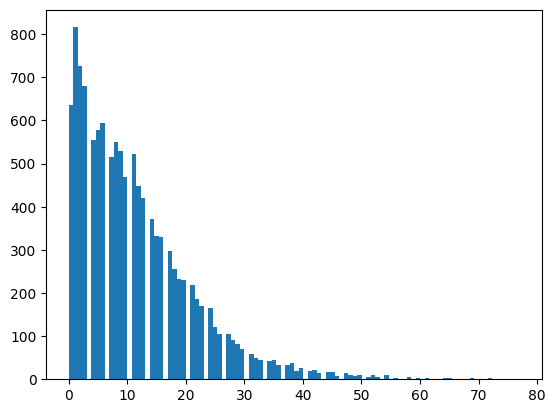

In [12]:
# set FOS to 0
plt.hist(counts_array[:, FOS_idx], bins=100);

In [14]:
# set FOS to 0
counts_array[:, FOS_idx] = 0

In [15]:
# modify adata to have FOS set to 0
adata.X = counts_array

adata.X[:, FOS_idx].sum()

0.0

In [17]:
# save modified adata as h5ad in ./data
adata.write("./data/10k_pbmcs_proc_noFOS.h5ad")